## Step 4 - Develop Model - Task 4. Classification - CLASS ASSIGNMENT


###Load Libraries


In [ ]:
!pip install sklearn --upgrade

Requirement already up-to-date: sklearn in /usr/local/lib/python3.6/dist-packages (0.0)


In [1]:
import pandas as pd
import numpy as np

from datetime import date
from datetime import timedelta

import matplotlib.pyplot as plt

from sklearn import preprocessing

from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score

from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Set up environment and connect to Google Drive

In [2]:
using_Google_colab = True
using_Anaconda_on_Mac_or_Linux = False
using_Anaconda_on_windows = False

In [3]:
if using_Google_colab:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


## DM4.1 - Open Notebook and sample LA county from Analytics Base Table, compute monthly differences - Activity 1


### Upload State level Data


In [4]:
if using_Google_colab:
  abt_by_county = pd.read_csv('/content/drive/MyDrive/COVID_Project/output/abt_by_county.csv',
                              index_col=['Date'], parse_dates=['Date'])
if using_Anaconda_on_Mac_or_Linux:
  abt_by_county = pd.read_csv('../output/abt_by_county.csv',
                              index_col=['Date'], parse_dates=['Date'])
if using_Anaconda_on_windows:
  abt_by_county = pd.read_csv(r'..\output\abt_by_county.csv',
                              index_col=['Date'], parse_dates=['Date'])
abt_by_county

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,County Name,countyFIPS,State,stateFIPS,Total Cases,Incremental Cases,cases moving_average,Total Deaths,Incremental Deaths,death moving_average,population,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0,0,334,Kent County,10001,DE,10,0,NaN,NaN,0,NaN,NaN,180786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-23,1,1,335,Kent County,10001,DE,10,0,0.0,NaN,0,0.0,NaN,180786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-24,2,2,336,Kent County,10001,DE,10,0,0.0,NaN,0,0.0,NaN,180786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-25,3,3,337,Kent County,10001,DE,10,0,0.0,NaN,0,0.0,NaN,180786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-26,4,4,338,Kent County,10001,DE,10,0,0.0,NaN,0,0.0,NaN,180786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-16,1050091,1050091,1050425,Windham County,9015,CT,9,3921,130.0,90.142857,48,2.0,1.714286,116782,US,United States,Connecticut,Windham County,NaN,NaN,9015.0,2020-12-16,16.0,49.0,23.0,-26.0,-22.0,9.0
2020-12-17,1050092,1050092,1050426,Windham County,9015,CT,9,3998,77.0,90.285714,51,3.0,1.571429,116782,US,United States,Connecticut,Windham County,NaN,NaN,9015.0,2020-12-17,-57.0,-52.0,-49.0,-69.0,-68.0,30.0
2020-12-18,1050093,1050093,1050427,Windham County,9015,CT,9,4153,155.0,103.714286,51,0.0,1.285714,116782,US,United States,Connecticut,Windham County,NaN,NaN,9015.0,2020-12-18,-11.0,5.0,-20.0,-35.0,-24.0,13.0


In [5]:
abt_by_county = abt_by_county.rename(columns={'retail_and_recreation_percent_change_from_baseline' : 'retail_recreation',
                                              'grocery_and_pharmacy_percent_change_from_baseline' : 'grocery_pharmacy', 
                                              'parks_percent_change_from_baseline' : 'parks',
                                              'transit_stations_percent_change_from_baseline' : 'transit',
                                              'workplaces_percent_change_from_baseline' : 'workplaces',
                                              'residential_percent_change_from_baseline' : 'residential'})
abt_by_county                        

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,County Name,countyFIPS,State,stateFIPS,Total Cases,Incremental Cases,cases moving_average,Total Deaths,Incremental Deaths,death moving_average,population,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,date,retail_recreation,grocery_pharmacy,parks,transit,workplaces,residential
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0,0,334,Kent County,10001,DE,10,0,NaN,NaN,0,NaN,NaN,180786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-23,1,1,335,Kent County,10001,DE,10,0,0.0,NaN,0,0.0,NaN,180786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-24,2,2,336,Kent County,10001,DE,10,0,0.0,NaN,0,0.0,NaN,180786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-25,3,3,337,Kent County,10001,DE,10,0,0.0,NaN,0,0.0,NaN,180786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-26,4,4,338,Kent County,10001,DE,10,0,0.0,NaN,0,0.0,NaN,180786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-16,1050091,1050091,1050425,Windham County,9015,CT,9,3921,130.0,90.142857,48,2.0,1.714286,116782,US,United States,Connecticut,Windham County,NaN,NaN,9015.0,2020-12-16,16.0,49.0,23.0,-26.0,-22.0,9.0
2020-12-17,1050092,1050092,1050426,Windham County,9015,CT,9,3998,77.0,90.285714,51,3.0,1.571429,116782,US,United States,Connecticut,Windham County,NaN,NaN,9015.0,2020-12-17,-57.0,-52.0,-49.0,-69.0,-68.0,30.0
2020-12-18,1050093,1050093,1050427,Windham County,9015,CT,9,4153,155.0,103.714286,51,0.0,1.285714,116782,US,United States,Connecticut,Windham County,NaN,NaN,9015.0,2020-12-18,-11.0,5.0,-20.0,-35.0,-24.0,13.0


### Filter data for LA County

In [6]:
abt_LA_county = abt_by_county[abt_by_county['County Name'] == 'Los Angeles County']
abt_LA_county

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,County Name,countyFIPS,State,stateFIPS,Total Cases,Incremental Cases,cases moving_average,Total Deaths,Incremental Deaths,death moving_average,population,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,date,retail_recreation,grocery_pharmacy,parks,transit,workplaces,residential
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-22,1012688,1012688,1013022,Los Angeles County,6037,CA,6,0,NaN,NaN,0,NaN,NaN,10039107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-23,1012689,1012689,1013023,Los Angeles County,6037,CA,6,0,0.0,NaN,0,0.0,NaN,10039107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-24,1012690,1012690,1013024,Los Angeles County,6037,CA,6,0,0.0,NaN,0,0.0,NaN,10039107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-25,1012691,1012691,1013025,Los Angeles County,6037,CA,6,0,0.0,NaN,0,0.0,NaN,10039107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-26,1012692,1012692,1013026,Los Angeles County,6037,CA,6,1,1.0,NaN,0,0.0,NaN,10039107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-16,1013017,1013017,1013351,Los Angeles County,6037,CA,6,566005,22236.0,12962.000000,8568,137.0,70.428571,10039107,US,United States,California,Los Angeles County,NaN,NaN,6037.0,2020-12-16,-33.0,-15.0,-30.0,-47.0,-43.0,16.0
2020-12-17,1013018,1013018,1013352,Los Angeles County,6037,CA,6,580325,14320.0,13201.142857,8664,96.0,73.571429,10039107,US,United States,California,Los Angeles County,NaN,NaN,6037.0,2020-12-17,-33.0,-15.0,-36.0,-47.0,-43.0,17.0
2020-12-18,1013019,1013019,1013353,Los Angeles County,6037,CA,6,596721,16396.0,13583.714286,8757,93.0,79.714286,10039107,US,United States,California,Los Angeles County,NaN,NaN,6037.0,2020-12-18,-34.0,-13.0,-33.0,-46.0,-42.0,17.0


### Calculate monthly summary of cases and force date to end of month

In [7]:
inc_cases_LA = abt_LA_county[['countyFIPS',
                              'Incremental Cases', 
                              'population']]
inc_cases_LA_month = inc_cases_LA.groupby(['countyFIPS'])['Incremental Cases',
                                                          'population'].resample('M').mean().reset_index()
inc_cases_LA_month['Month'] = inc_cases_LA_month['Date'] + pd.offsets.MonthEnd(0) 
inc_cases_LA_month

,countyFIPS,Date,Incremental Cases,population,Month
0,6037,2020-01-31,0.111111,10039107,2020-01-31
1,6037,2020-02-29,0.000000,10039107,2020-02-29
2,6037,2020-03-31,97.096774,10039107,2020-03-31
3,6037,2020-04-30,672.366667,10039107,2020-04-30
4,6037,2020-05-31,1026.258065,10039107,2020-05-31
5,6037,2020-06-30,1617.766667,10039107,2020-06-30
6,6037,2020-07-31,2740.387097,10039107,2020-07-31
7,6037,2020-08-31,1718.935484,10039107,2020-08-31
8,6037,2020-09-30,951.033333,10039107,2020-09-30
9,6037,2020-10-31,1203.838710,10039107,2020-10-31


### Select Google Social Mobility data

In [8]:
google_LA = abt_LA_county[['countyFIPS',
                           'retail_recreation',
                           'grocery_pharmacy',
                           'parks',
                           'transit',
                           'workplaces',
                           'residential']]


### Create Monthly summaries



In [9]:
google_LA_month = google_LA.groupby(['countyFIPS'])['retail_recreation',
                                                    'grocery_pharmacy',
                                                    'parks',
                                                    'transit',
                                                    'workplaces',
                                                    'residential'].resample('M').mean().reset_index()
google_LA_month['Original Month'] = google_LA_month['Date'] + pd.offsets.MonthEnd(0) 
google_LA_month                                                                    

,countyFIPS,Date,retail_recreation,grocery_pharmacy,parks,transit,workplaces,residential,Original Month
0,6037,2020-01-31,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-31
1,6037,2020-02-29,2.066667,0.666667,11.933333,-0.066667,-0.333333,0.000000,2020-02-29
2,6037,2020-03-31,-21.064516,-1.806452,-19.903226,-27.483871,-21.483871,10.935484,2020-03-31
3,6037,2020-04-30,-51.766667,-22.066667,-44.900000,-52.600000,-48.566667,22.166667,2020-04-30
4,6037,2020-05-31,-45.741935,-12.096774,-18.806452,-43.967742,-40.709677,17.580645,2020-05-31
5,6037,2020-06-30,-34.033333,-10.466667,-8.866667,-38.533333,-34.500000,13.833333,2020-06-30
6,6037,2020-07-31,-32.096774,-10.483871,-6.935484,-40.096774,-37.580645,13.677419,2020-07-31
7,6037,2020-08-31,-31.290323,-12.129032,-7.516129,-38.967742,-35.322581,12.129032,2020-08-31
8,6037,2020-09-30,-30.500000,-13.533333,-16.766667,-40.166667,-35.900000,12.066667,2020-09-30
9,6037,2020-10-31,-29.677419,-12.806452,-19.709677,-36.709677,-32.290323,11.129032,2020-10-31


### Compute monthly difference

In [10]:
inc_cases_LA_month['Case Change'] = inc_cases_LA_month.groupby('countyFIPS')['Incremental Cases'].apply(lambda x: x - x.shift(1))
inc_cases_LA_month

,countyFIPS,Date,Incremental Cases,population,Month,Case Change
0,6037,2020-01-31,0.111111,10039107,2020-01-31,NaN
1,6037,2020-02-29,0.000000,10039107,2020-02-29,-0.111111
2,6037,2020-03-31,97.096774,10039107,2020-03-31,97.096774
3,6037,2020-04-30,672.366667,10039107,2020-04-30,575.269892
4,6037,2020-05-31,1026.258065,10039107,2020-05-31,353.891398
5,6037,2020-06-30,1617.766667,10039107,2020-06-30,591.508602
6,6037,2020-07-31,2740.387097,10039107,2020-07-31,1122.620430
7,6037,2020-08-31,1718.935484,10039107,2020-08-31,-1021.451613
8,6037,2020-09-30,951.033333,10039107,2020-09-30,-767.902151
9,6037,2020-10-31,1203.838710,10039107,2020-10-31,252.805376


In [11]:
google_LA_month['delta_retail_recreation'] = google_LA_month.groupby('countyFIPS')['retail_recreation'].apply(lambda x: x - x.shift(1))
google_LA_month['delta_grocery_pharmacy'] = google_LA_month.groupby('countyFIPS')['grocery_pharmacy'].apply(lambda x: x - x.shift(1))
google_LA_month['delta_parks'] = google_LA_month.groupby('countyFIPS')['parks'].apply(lambda x: x - x.shift(1))
google_LA_month['delta_transit'] = google_LA_month.groupby('countyFIPS')['transit'].apply(lambda x: x - x.shift(1))
google_LA_month['delta_workplaces'] = google_LA_month.groupby('countyFIPS')['workplaces'].apply(lambda x: x - x.shift(1))
google_LA_month['delta_residential'] = google_LA_month.groupby('countyFIPS')['residential'].apply(lambda x: x - x.shift(1))
google_LA_month

,countyFIPS,Date,retail_recreation,grocery_pharmacy,parks,transit,workplaces,residential,Original Month,delta_retail_recreation,delta_grocery_pharmacy,delta_parks,delta_transit,delta_workplaces,delta_residential
0,6037,2020-01-31,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-31,NaN,NaN,NaN,NaN,NaN,NaN
1,6037,2020-02-29,2.066667,0.666667,11.933333,-0.066667,-0.333333,0.000000,2020-02-29,NaN,NaN,NaN,NaN,NaN,NaN
2,6037,2020-03-31,-21.064516,-1.806452,-19.903226,-27.483871,-21.483871,10.935484,2020-03-31,-23.131183,-2.473118,-31.836559,-27.417204,-21.150538,10.935484
3,6037,2020-04-30,-51.766667,-22.066667,-44.900000,-52.600000,-48.566667,22.166667,2020-04-30,-30.702151,-20.260215,-24.996774,-25.116129,-27.082796,11.231183
4,6037,2020-05-31,-45.741935,-12.096774,-18.806452,-43.967742,-40.709677,17.580645,2020-05-31,6.024731,9.969892,26.093548,8.632258,7.856989,-4.586022
5,6037,2020-06-30,-34.033333,-10.466667,-8.866667,-38.533333,-34.500000,13.833333,2020-06-30,11.708602,1.630108,9.939785,5.434409,6.209677,-3.747312
6,6037,2020-07-31,-32.096774,-10.483871,-6.935484,-40.096774,-37.580645,13.677419,2020-07-31,1.936559,-0.017204,1.931183,-1.563441,-3.080645,-0.155914
7,6037,2020-08-31,-31.290323,-12.129032,-7.516129,-38.967742,-35.322581,12.129032,2020-08-31,0.806452,-1.645161,-0.580645,1.129032,2.258065,-1.548387
8,6037,2020-09-30,-30.500000,-13.533333,-16.766667,-40.166667,-35.900000,12.066667,2020-09-30,0.790323,-1.404301,-9.250538,-1.198925,-0.577419,-0.062366
9,6037,2020-10-31,-29.677419,-12.806452,-19.709677,-36.709677,-32.290323,11.129032,2020-10-31,0.822581,0.726882,-2.943011,3.456989,3.609677,-0.937634


## DM4.2 - Shift social mobility data by month and merge with cases data, convert monthly change to a qualitative difference 


### Shift google data by one month 

In [12]:
#google_LA_month_lagged = google_LA_month
google_LA_month['Month'] = google_LA_month['Original Month'] + pd.DateOffset(months=1) + pd.offsets.MonthEnd(0) 
google_LA_month

,countyFIPS,Date,retail_recreation,grocery_pharmacy,parks,transit,workplaces,residential,Original Month,delta_retail_recreation,delta_grocery_pharmacy,delta_parks,delta_transit,delta_workplaces,delta_residential,Month
0,6037,2020-01-31,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-31,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-29
1,6037,2020-02-29,2.066667,0.666667,11.933333,-0.066667,-0.333333,0.000000,2020-02-29,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-31
2,6037,2020-03-31,-21.064516,-1.806452,-19.903226,-27.483871,-21.483871,10.935484,2020-03-31,-23.131183,-2.473118,-31.836559,-27.417204,-21.150538,10.935484,2020-04-30
3,6037,2020-04-30,-51.766667,-22.066667,-44.900000,-52.600000,-48.566667,22.166667,2020-04-30,-30.702151,-20.260215,-24.996774,-25.116129,-27.082796,11.231183,2020-05-31
4,6037,2020-05-31,-45.741935,-12.096774,-18.806452,-43.967742,-40.709677,17.580645,2020-05-31,6.024731,9.969892,26.093548,8.632258,7.856989,-4.586022,2020-06-30
5,6037,2020-06-30,-34.033333,-10.466667,-8.866667,-38.533333,-34.500000,13.833333,2020-06-30,11.708602,1.630108,9.939785,5.434409,6.209677,-3.747312,2020-07-31
6,6037,2020-07-31,-32.096774,-10.483871,-6.935484,-40.096774,-37.580645,13.677419,2020-07-31,1.936559,-0.017204,1.931183,-1.563441,-3.080645,-0.155914,2020-08-31
7,6037,2020-08-31,-31.290323,-12.129032,-7.516129,-38.967742,-35.322581,12.129032,2020-08-31,0.806452,-1.645161,-0.580645,1.129032,2.258065,-1.548387,2020-09-30
8,6037,2020-09-30,-30.500000,-13.533333,-16.766667,-40.166667,-35.900000,12.066667,2020-09-30,0.790323,-1.404301,-9.250538,-1.198925,-0.577419,-0.062366,2020-10-31
9,6037,2020-10-31,-29.677419,-12.806452,-19.709677,-36.709677,-32.290323,11.129032,2020-10-31,0.822581,0.726882,-2.943011,3.456989,3.609677,-0.937634,2020-11-30


### Merge incremental cases and google DataFrames

In [13]:
merged_LA = pd.merge(inc_cases_LA_month, 
                     google_LA_month, 
                     on=['countyFIPS', 'Month'], 
                     suffixes=('', '_DROP'), 
                     how='inner').filter(regex='^(?!.*_DROP)')
merged_LA

,countyFIPS,Date,Incremental Cases,population,Month,Case Change,retail_recreation,grocery_pharmacy,parks,transit,workplaces,residential,Original Month,delta_retail_recreation,delta_grocery_pharmacy,delta_parks,delta_transit,delta_workplaces,delta_residential
0,6037,2020-02-29,0.000000,10039107,2020-02-29,-0.111111,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-31,NaN,NaN,NaN,NaN,NaN,NaN
1,6037,2020-03-31,97.096774,10039107,2020-03-31,97.096774,2.066667,0.666667,11.933333,-0.066667,-0.333333,0.000000,2020-02-29,NaN,NaN,NaN,NaN,NaN,NaN
2,6037,2020-04-30,672.366667,10039107,2020-04-30,575.269892,-21.064516,-1.806452,-19.903226,-27.483871,-21.483871,10.935484,2020-03-31,-23.131183,-2.473118,-31.836559,-27.417204,-21.150538,10.935484
3,6037,2020-05-31,1026.258065,10039107,2020-05-31,353.891398,-51.766667,-22.066667,-44.900000,-52.600000,-48.566667,22.166667,2020-04-30,-30.702151,-20.260215,-24.996774,-25.116129,-27.082796,11.231183
4,6037,2020-06-30,1617.766667,10039107,2020-06-30,591.508602,-45.741935,-12.096774,-18.806452,-43.967742,-40.709677,17.580645,2020-05-31,6.024731,9.969892,26.093548,8.632258,7.856989,-4.586022
5,6037,2020-07-31,2740.387097,10039107,2020-07-31,1122.620430,-34.033333,-10.466667,-8.866667,-38.533333,-34.500000,13.833333,2020-06-30,11.708602,1.630108,9.939785,5.434409,6.209677,-3.747312
6,6037,2020-08-31,1718.935484,10039107,2020-08-31,-1021.451613,-32.096774,-10.483871,-6.935484,-40.096774,-37.580645,13.677419,2020-07-31,1.936559,-0.017204,1.931183,-1.563441,-3.080645,-0.155914
7,6037,2020-09-30,951.033333,10039107,2020-09-30,-767.902151,-31.290323,-12.129032,-7.516129,-38.967742,-35.322581,12.129032,2020-08-31,0.806452,-1.645161,-0.580645,1.129032,2.258065,-1.548387
8,6037,2020-10-31,1203.838710,10039107,2020-10-31,252.805376,-30.500000,-13.533333,-16.766667,-40.166667,-35.900000,12.066667,2020-09-30,0.790323,-1.404301,-9.250538,-1.198925,-0.577419,-0.062366
9,6037,2020-11-30,3110.033333,10039107,2020-11-30,1906.194624,-29.677419,-12.806452,-19.709677,-36.709677,-32.290323,11.129032,2020-10-31,0.822581,0.726882,-2.943011,3.456989,3.609677,-0.937634


### Convert to categorical data

In [14]:
def convert_to_categorical(x):
    if x <= 0:
        return -1
    return 1

In [15]:
merged_LA = merged_LA.fillna(0)
merged_LA['case_direction'] = merged_LA['Case Change'].apply(convert_to_categorical)
merged_LA

,countyFIPS,Date,Incremental Cases,population,Month,Case Change,retail_recreation,grocery_pharmacy,parks,transit,workplaces,residential,Original Month,delta_retail_recreation,delta_grocery_pharmacy,delta_parks,delta_transit,delta_workplaces,delta_residential,case_direction
0,6037,2020-02-29,0.000000,10039107,2020-02-29,-0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2020-01-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1
1,6037,2020-03-31,97.096774,10039107,2020-03-31,97.096774,2.066667,0.666667,11.933333,-0.066667,-0.333333,0.000000,2020-02-29,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
2,6037,2020-04-30,672.366667,10039107,2020-04-30,575.269892,-21.064516,-1.806452,-19.903226,-27.483871,-21.483871,10.935484,2020-03-31,-23.131183,-2.473118,-31.836559,-27.417204,-21.150538,10.935484,1
3,6037,2020-05-31,1026.258065,10039107,2020-05-31,353.891398,-51.766667,-22.066667,-44.900000,-52.600000,-48.566667,22.166667,2020-04-30,-30.702151,-20.260215,-24.996774,-25.116129,-27.082796,11.231183,1
4,6037,2020-06-30,1617.766667,10039107,2020-06-30,591.508602,-45.741935,-12.096774,-18.806452,-43.967742,-40.709677,17.580645,2020-05-31,6.024731,9.969892,26.093548,8.632258,7.856989,-4.586022,1
5,6037,2020-07-31,2740.387097,10039107,2020-07-31,1122.620430,-34.033333,-10.466667,-8.866667,-38.533333,-34.500000,13.833333,2020-06-30,11.708602,1.630108,9.939785,5.434409,6.209677,-3.747312,1
6,6037,2020-08-31,1718.935484,10039107,2020-08-31,-1021.451613,-32.096774,-10.483871,-6.935484,-40.096774,-37.580645,13.677419,2020-07-31,1.936559,-0.017204,1.931183,-1.563441,-3.080645,-0.155914,-1
7,6037,2020-09-30,951.033333,10039107,2020-09-30,-767.902151,-31.290323,-12.129032,-7.516129,-38.967742,-35.322581,12.129032,2020-08-31,0.806452,-1.645161,-0.580645,1.129032,2.258065,-1.548387,-1
8,6037,2020-10-31,1203.838710,10039107,2020-10-31,252.805376,-30.500000,-13.533333,-16.766667,-40.166667,-35.900000,12.066667,2020-09-30,0.790323,-1.404301,-9.250538,-1.198925,-0.577419,-0.062366,1
9,6037,2020-11-30,3110.033333,10039107,2020-11-30,1906.194624,-29.677419,-12.806452,-19.709677,-36.709677,-32.290323,11.129032,2020-10-31,0.822581,0.726882,-2.943011,3.456989,3.609677,-0.937634,1


In [16]:
merged_LA = merged_LA[2:]
merged_LA

,countyFIPS,Date,Incremental Cases,population,Month,Case Change,retail_recreation,grocery_pharmacy,parks,transit,workplaces,residential,Original Month,delta_retail_recreation,delta_grocery_pharmacy,delta_parks,delta_transit,delta_workplaces,delta_residential,case_direction
2,6037,2020-04-30,672.366667,10039107,2020-04-30,575.269892,-21.064516,-1.806452,-19.903226,-27.483871,-21.483871,10.935484,2020-03-31,-23.131183,-2.473118,-31.836559,-27.417204,-21.150538,10.935484,1
3,6037,2020-05-31,1026.258065,10039107,2020-05-31,353.891398,-51.766667,-22.066667,-44.900000,-52.600000,-48.566667,22.166667,2020-04-30,-30.702151,-20.260215,-24.996774,-25.116129,-27.082796,11.231183,1
4,6037,2020-06-30,1617.766667,10039107,2020-06-30,591.508602,-45.741935,-12.096774,-18.806452,-43.967742,-40.709677,17.580645,2020-05-31,6.024731,9.969892,26.093548,8.632258,7.856989,-4.586022,1
5,6037,2020-07-31,2740.387097,10039107,2020-07-31,1122.620430,-34.033333,-10.466667,-8.866667,-38.533333,-34.500000,13.833333,2020-06-30,11.708602,1.630108,9.939785,5.434409,6.209677,-3.747312,1
6,6037,2020-08-31,1718.935484,10039107,2020-08-31,-1021.451613,-32.096774,-10.483871,-6.935484,-40.096774,-37.580645,13.677419,2020-07-31,1.936559,-0.017204,1.931183,-1.563441,-3.080645,-0.155914,-1
7,6037,2020-09-30,951.033333,10039107,2020-09-30,-767.902151,-31.290323,-12.129032,-7.516129,-38.967742,-35.322581,12.129032,2020-08-31,0.806452,-1.645161,-0.580645,1.129032,2.258065,-1.548387,-1
8,6037,2020-10-31,1203.838710,10039107,2020-10-31,252.805376,-30.500000,-13.533333,-16.766667,-40.166667,-35.900000,12.066667,2020-09-30,0.790323,-1.404301,-9.250538,-1.198925,-0.577419,-0.062366,1
9,6037,2020-11-30,3110.033333,10039107,2020-11-30,1906.194624,-29.677419,-12.806452,-19.709677,-36.709677,-32.290323,11.129032,2020-10-31,0.822581,0.726882,-2.943011,3.456989,3.609677,-0.937634,1
10,6037,2020-12-31,11137.550000,10039107,2020-12-31,8027.516667,-31.300000,-13.933333,-27.733333,-42.300000,-34.866667,12.600000,2020-11-30,-1.622581,-1.126882,-8.023656,-5.590323,-2.576344,1.470968,1


### Save Intermediate results

In [ ]:
merged_LA.to_csv('/content/drive/MyDrive/COVID_Project/output/merged_LA.csv')

## DM4.3 - Develop decision-tree with all 6 mobility parameters for LA county 


### Prepare and apply the model


In [17]:
y_LA = merged_LA['case_direction'].values
X_LA = merged_LA[['delta_retail_recreation', 
               'delta_grocery_pharmacy', 
               'delta_parks', 
               'delta_transit', 
               'delta_workplaces', 
               'delta_residential']].values
X_LA

array([[-2.31311828e+01, -2.47311828e+00, -3.18365591e+01,
        -2.74172043e+01, -2.11505376e+01,  1.09354839e+01],
       [-3.07021505e+01, -2.02602151e+01, -2.49967742e+01,
        -2.51161290e+01, -2.70827957e+01,  1.12311828e+01],
       [ 6.02473118e+00,  9.96989247e+00,  2.60935484e+01,
         8.63225806e+00,  7.85698925e+00, -4.58602151e+00],
       [ 1.17086022e+01,  1.63010753e+00,  9.93978495e+00,
         5.43440860e+00,  6.20967742e+00, -3.74731183e+00],
       [ 1.93655914e+00, -1.72043011e-02,  1.93118280e+00,
        -1.56344086e+00, -3.08064516e+00, -1.55913978e-01],
       [ 8.06451613e-01, -1.64516129e+00, -5.80645161e-01,
         1.12903226e+00,  2.25806452e+00, -1.54838710e+00],
       [ 7.90322581e-01, -1.40430108e+00, -9.25053763e+00,
        -1.19892473e+00, -5.77419355e-01, -6.23655914e-02],
       [ 8.22580645e-01,  7.26881720e-01, -2.94301075e+00,
         3.45698925e+00,  3.60967742e+00, -9.37634409e-01],
       [-1.62258065e+00, -1.12688172e+00, -8.023

In [18]:
y_LA

array([ 1,  1,  1,  1, -1, -1,  1,  1,  1])

In [20]:
decision_tree = DecisionTreeClassifier()
model_LA = decision_tree.fit(X_LA, y_LA)

### Following function may not work correctly in Anaconda. Try Google Colab if having problem in Anaconda


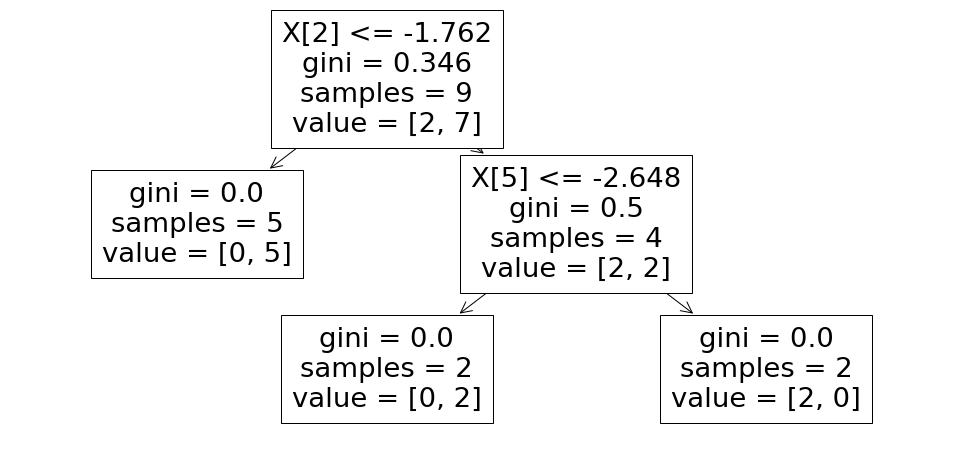

In [21]:
 plt.figure(figsize=(17,8))
 tree.plot_tree(model_LA, max_depth=2)
 plt.show()

In [22]:
print(decision_tree.feature_importances_)

[0.         0.         0.35714286 0.         0.         0.64285714]


## DM4.4 - Develop decision-tree  with all 6 mobility parameters for all counties 


### Calculate monthly summary of cases and force date to end of month for all counties


In [23]:
inc_cases = abt_by_county[['countyFIPS',
                           'Incremental Cases', 
                           'population']]
inc_cases_month = inc_cases.groupby(['countyFIPS'])['Incremental Cases',
                                                    'population'].resample('M').mean().reset_index()
inc_cases_month['Month'] = inc_cases_month['Date'] + pd.offsets.MonthEnd(0) 
inc_cases_month

,countyFIPS,Date,Incremental Cases,population,Month
0,1001,2020-01-31,0.000000,55869,2020-01-31
1,1001,2020-02-29,0.000000,55869,2020-02-29
2,1001,2020-03-31,0.225806,55869,2020-03-31
3,1001,2020-04-30,1.166667,55869,2020-04-30
4,1001,2020-05-31,5.741935,55869,2020-05-31
...,...,...,...,...,...
37723,56045,2020-08-31,0.451613,6927,2020-08-31
37724,56045,2020-09-30,0.666667,6927,2020-09-30
37725,56045,2020-10-31,3.870968,6927,2020-10-31
37726,56045,2020-11-30,7.933333,6927,2020-11-30


### Select Google Social Distancing Data for all counties

In [24]:
google_all = abt_by_county[['countyFIPS',
                            'retail_recreation',
                            'grocery_pharmacy',
                            'parks',
                            'transit',
                            'workplaces',
                            'residential']]

### For Google darta create monthly summaries

In [25]:
google_month = google_all.groupby(['countyFIPS'])['retail_recreation',
                                                  'grocery_pharmacy',
                                                  'parks',
                                                  'transit',
                                                  'workplaces',
                                                  'residential'].resample('M').mean().reset_index()
google_month['Original Month'] = google_month['Date'] + pd.offsets.MonthEnd(0) 
google_month  

,countyFIPS,Date,retail_recreation,grocery_pharmacy,parks,transit,workplaces,residential,Original Month
0,1001,2020-01-31,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-31
1,1001,2020-02-29,4.733333,2.533333,-23.0,NaN,0.266667,0.200000,2020-02-29
2,1001,2020-03-31,-6.354839,12.612903,-14.0,NaN,-13.419355,6.090909,2020-03-31
3,1001,2020-04-30,-25.700000,4.033333,-49.5,NaN,-37.833333,15.863636,2020-04-30
4,1001,2020-05-31,-3.677419,13.548387,NaN,NaN,-27.451613,10.850000,2020-05-31
...,...,...,...,...,...,...,...,...,...
37723,56045,2020-08-31,NaN,NaN,NaN,NaN,-23.200000,NaN,2020-08-31
37724,56045,2020-09-30,NaN,NaN,NaN,NaN,-14.000000,NaN,2020-09-30
37725,56045,2020-10-31,NaN,NaN,NaN,NaN,-13.272727,NaN,2020-10-31
37726,56045,2020-11-30,NaN,NaN,NaN,NaN,-24.095238,NaN,2020-11-30


### Compute monthly difference for all data

In [26]:
inc_cases_month['Case Change'] = inc_cases_month.groupby('countyFIPS')['Incremental Cases'].apply(lambda x: x - x.shift(1))
inc_cases_month

,countyFIPS,Date,Incremental Cases,population,Month,Case Change
0,1001,2020-01-31,0.000000,55869,2020-01-31,NaN
1,1001,2020-02-29,0.000000,55869,2020-02-29,0.000000
2,1001,2020-03-31,0.225806,55869,2020-03-31,0.225806
3,1001,2020-04-30,1.166667,55869,2020-04-30,0.940860
4,1001,2020-05-31,5.741935,55869,2020-05-31,4.575269
...,...,...,...,...,...,...
37723,56045,2020-08-31,0.451613,6927,2020-08-31,0.354839
37724,56045,2020-09-30,0.666667,6927,2020-09-30,0.215054
37725,56045,2020-10-31,3.870968,6927,2020-10-31,3.204301
37726,56045,2020-11-30,7.933333,6927,2020-11-30,4.062366


In [27]:
google_month['delta_retail_recreation'] = google_month.groupby('countyFIPS')['retail_recreation'].apply(lambda x: x - x.shift(1))
google_month['delta_grocery_pharmacy'] = google_month.groupby('countyFIPS')['grocery_pharmacy'].apply(lambda x: x - x.shift(1))
google_month['delta_parks'] = google_month.groupby('countyFIPS')['parks'].apply(lambda x: x - x.shift(1))
google_month['delta_transit'] = google_month.groupby('countyFIPS')['transit'].apply(lambda x: x - x.shift(1))
google_month['delta_workplaces'] = google_month.groupby('countyFIPS')['workplaces'].apply(lambda x: x - x.shift(1))
google_month['delta_residential'] = google_month.groupby('countyFIPS')['residential'].apply(lambda x: x - x.shift(1))
google_month

,countyFIPS,Date,retail_recreation,grocery_pharmacy,parks,transit,workplaces,residential,Original Month,delta_retail_recreation,delta_grocery_pharmacy,delta_parks,delta_transit,delta_workplaces,delta_residential
0,1001,2020-01-31,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-31,NaN,NaN,NaN,NaN,NaN,NaN
1,1001,2020-02-29,4.733333,2.533333,-23.0,NaN,0.266667,0.200000,2020-02-29,NaN,NaN,NaN,NaN,NaN,NaN
2,1001,2020-03-31,-6.354839,12.612903,-14.0,NaN,-13.419355,6.090909,2020-03-31,-11.088172,10.079570,9.0,NaN,-13.686022,5.890909
3,1001,2020-04-30,-25.700000,4.033333,-49.5,NaN,-37.833333,15.863636,2020-04-30,-19.345161,-8.579570,-35.5,NaN,-24.413978,9.772727
4,1001,2020-05-31,-3.677419,13.548387,NaN,NaN,-27.451613,10.850000,2020-05-31,22.022581,9.515054,NaN,NaN,10.381720,-5.013636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37723,56045,2020-08-31,NaN,NaN,NaN,NaN,-23.200000,NaN,2020-08-31,NaN,NaN,NaN,NaN,2.365217,NaN
37724,56045,2020-09-30,NaN,NaN,NaN,NaN,-14.000000,NaN,2020-09-30,NaN,NaN,NaN,NaN,9.200000,NaN
37725,56045,2020-10-31,NaN,NaN,NaN,NaN,-13.272727,NaN,2020-10-31,NaN,NaN,NaN,NaN,0.727273,NaN
37726,56045,2020-11-30,NaN,NaN,NaN,NaN,-24.095238,NaN,2020-11-30,NaN,NaN,NaN,NaN,-10.822511,NaN


### Shift all county Google data by one month

In [28]:
google_month['Month'] = google_month['Original Month'] + pd.DateOffset(months=1) + pd.offsets.MonthEnd(0) 
google_month

,countyFIPS,Date,retail_recreation,grocery_pharmacy,parks,transit,workplaces,residential,Original Month,delta_retail_recreation,delta_grocery_pharmacy,delta_parks,delta_transit,delta_workplaces,delta_residential,Month
0,1001,2020-01-31,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-31,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-29
1,1001,2020-02-29,4.733333,2.533333,-23.0,NaN,0.266667,0.200000,2020-02-29,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-31
2,1001,2020-03-31,-6.354839,12.612903,-14.0,NaN,-13.419355,6.090909,2020-03-31,-11.088172,10.079570,9.0,NaN,-13.686022,5.890909,2020-04-30
3,1001,2020-04-30,-25.700000,4.033333,-49.5,NaN,-37.833333,15.863636,2020-04-30,-19.345161,-8.579570,-35.5,NaN,-24.413978,9.772727,2020-05-31
4,1001,2020-05-31,-3.677419,13.548387,NaN,NaN,-27.451613,10.850000,2020-05-31,22.022581,9.515054,NaN,NaN,10.381720,-5.013636,2020-06-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37723,56045,2020-08-31,NaN,NaN,NaN,NaN,-23.200000,NaN,2020-08-31,NaN,NaN,NaN,NaN,2.365217,NaN,2020-09-30
37724,56045,2020-09-30,NaN,NaN,NaN,NaN,-14.000000,NaN,2020-09-30,NaN,NaN,NaN,NaN,9.200000,NaN,2020-10-31
37725,56045,2020-10-31,NaN,NaN,NaN,NaN,-13.272727,NaN,2020-10-31,NaN,NaN,NaN,NaN,0.727273,NaN,2020-11-30
37726,56045,2020-11-30,NaN,NaN,NaN,NaN,-24.095238,NaN,2020-11-30,NaN,NaN,NaN,NaN,-10.822511,NaN,2020-12-31


### Merge Incremental cases and Google DataFrames

In [29]:
merged_all = pd.merge(inc_cases_month, google_month, on=['countyFIPS', 'Month'], suffixes=('', '_DROP'), how='inner').filter(regex='^(?!.*_DROP)')
merged_all

,countyFIPS,Date,Incremental Cases,population,Month,Case Change,retail_recreation,grocery_pharmacy,parks,transit,workplaces,residential,Original Month,delta_retail_recreation,delta_grocery_pharmacy,delta_parks,delta_transit,delta_workplaces,delta_residential
0,1001,2020-02-29,0.000000,55869,2020-02-29,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-31,NaN,NaN,NaN,NaN,NaN,NaN
1,1001,2020-03-31,0.225806,55869,2020-03-31,0.225806,4.733333,2.533333,-23.0,NaN,0.266667,0.200000,2020-02-29,NaN,NaN,NaN,NaN,NaN,NaN
2,1001,2020-04-30,1.166667,55869,2020-04-30,0.940860,-6.354839,12.612903,-14.0,NaN,-13.419355,6.090909,2020-03-31,-11.088172,10.079570,9.0,NaN,-13.686022,5.890909
3,1001,2020-05-31,5.741935,55869,2020-05-31,4.575269,-25.700000,4.033333,-49.5,NaN,-37.833333,15.863636,2020-04-30,-19.345161,-8.579570,-35.5,NaN,-24.413978,9.772727
4,1001,2020-06-30,10.566667,55869,2020-06-30,4.824731,-3.677419,13.548387,NaN,NaN,-27.451613,10.850000,2020-05-31,22.022581,9.515054,NaN,NaN,10.381720,-5.013636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34579,56045,2020-08-31,0.451613,6927,2020-08-31,0.354839,NaN,NaN,NaN,NaN,-25.565217,NaN,2020-07-31,NaN,NaN,NaN,NaN,-0.837945,NaN
34580,56045,2020-09-30,0.666667,6927,2020-09-30,0.215054,NaN,NaN,NaN,NaN,-23.200000,NaN,2020-08-31,NaN,NaN,NaN,NaN,2.365217,NaN
34581,56045,2020-10-31,3.870968,6927,2020-10-31,3.204301,NaN,NaN,NaN,NaN,-14.000000,NaN,2020-09-30,NaN,NaN,NaN,NaN,9.200000,NaN
34582,56045,2020-11-30,7.933333,6927,2020-11-30,4.062366,NaN,NaN,NaN,NaN,-13.272727,NaN,2020-10-31,NaN,NaN,NaN,NaN,0.727273,NaN


### Convert all counties data to categorical

In [30]:
merged_all = merged_all.fillna(0)
merged_all['case_direction'] = merged_all['Case Change'].apply(convert_to_categorical)
merged_all

,countyFIPS,Date,Incremental Cases,population,Month,Case Change,retail_recreation,grocery_pharmacy,parks,transit,workplaces,residential,Original Month,delta_retail_recreation,delta_grocery_pharmacy,delta_parks,delta_transit,delta_workplaces,delta_residential,case_direction
0,1001,2020-02-29,0.000000,55869,2020-02-29,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,2020-01-31,0.000000,0.000000,0.0,0.0,0.000000,0.000000,-1
1,1001,2020-03-31,0.225806,55869,2020-03-31,0.225806,4.733333,2.533333,-23.0,0.0,0.266667,0.200000,2020-02-29,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1
2,1001,2020-04-30,1.166667,55869,2020-04-30,0.940860,-6.354839,12.612903,-14.0,0.0,-13.419355,6.090909,2020-03-31,-11.088172,10.079570,9.0,0.0,-13.686022,5.890909,1
3,1001,2020-05-31,5.741935,55869,2020-05-31,4.575269,-25.700000,4.033333,-49.5,0.0,-37.833333,15.863636,2020-04-30,-19.345161,-8.579570,-35.5,0.0,-24.413978,9.772727,1
4,1001,2020-06-30,10.566667,55869,2020-06-30,4.824731,-3.677419,13.548387,0.0,0.0,-27.451613,10.850000,2020-05-31,22.022581,9.515054,0.0,0.0,10.381720,-5.013636,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34579,56045,2020-08-31,0.451613,6927,2020-08-31,0.354839,0.000000,0.000000,0.0,0.0,-25.565217,0.000000,2020-07-31,0.000000,0.000000,0.0,0.0,-0.837945,0.000000,1
34580,56045,2020-09-30,0.666667,6927,2020-09-30,0.215054,0.000000,0.000000,0.0,0.0,-23.200000,0.000000,2020-08-31,0.000000,0.000000,0.0,0.0,2.365217,0.000000,1
34581,56045,2020-10-31,3.870968,6927,2020-10-31,3.204301,0.000000,0.000000,0.0,0.0,-14.000000,0.000000,2020-09-30,0.000000,0.000000,0.0,0.0,9.200000,0.000000,1
34582,56045,2020-11-30,7.933333,6927,2020-11-30,4.062366,0.000000,0.000000,0.0,0.0,-13.272727,0.000000,2020-10-31,0.000000,0.000000,0.0,0.0,0.727273,0.000000,1


### Save Interim results

In [ ]:
merged_all.to_csv('/content/drive/MyDrive/COVID_Project/output/merged_all.csv')

### Prepare and apply the model to all counties data

In [31]:
y_all = merged_all['case_direction'].values
X_all = merged_all[['delta_retail_recreation', 
                    'delta_grocery_pharmacy', 
                    'delta_parks', 
                    'delta_transit', 
                    'delta_workplaces', 
                    'delta_residential']].values
X_all.shape

(34584, 6)

In [32]:
y_all.shape

(34584,)

In [33]:
decision_tree_all = DecisionTreeClassifier()
model_all = decision_tree_all.fit(X_all, y_all)

In [34]:
X_all.shape

(34584, 6)

In [35]:
print(decision_tree_all.feature_importances_)

[0.15077558 0.13782522 0.0560631  0.07474566 0.4668956  0.11369484]


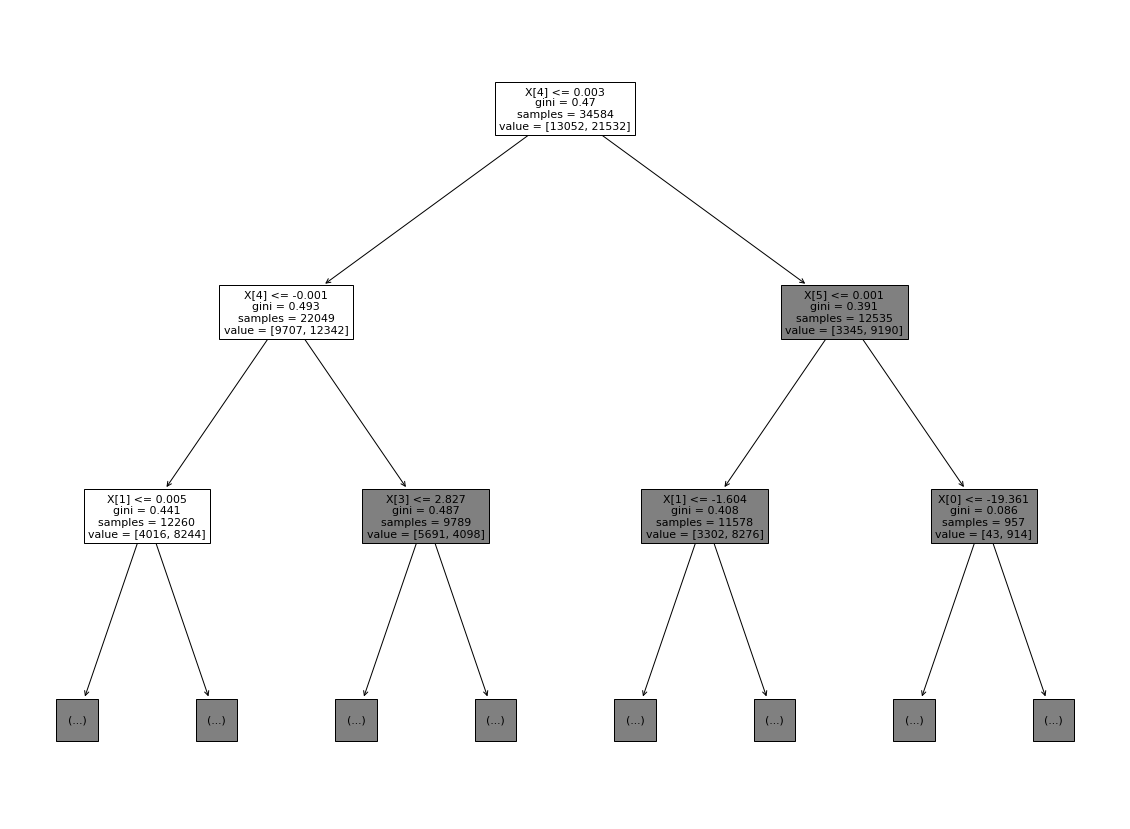

In [36]:
plt.figure(figsize=(20,15))
tree.plot_tree(model_all, max_depth=2)
plt.show()

## DM4.5 - Classify LA county and all county data using a different delay, for example 2 months - CLASS ASSIGNMENT

### Shift Google Mobility data by 2 months

In [37]:
google_LA_month['Month'] = google_LA_month['Original Month'] + pd.DateOffset(months=2) + pd.offsets.MonthEnd(0) 
google_LA_month

,countyFIPS,Date,retail_recreation,grocery_pharmacy,parks,transit,workplaces,residential,Original Month,delta_retail_recreation,delta_grocery_pharmacy,delta_parks,delta_transit,delta_workplaces,delta_residential,Month
0,6037,2020-01-31,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-31,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-31
1,6037,2020-02-29,2.066667,0.666667,11.933333,-0.066667,-0.333333,0.000000,2020-02-29,NaN,NaN,NaN,NaN,NaN,NaN,2020-04-30
2,6037,2020-03-31,-21.064516,-1.806452,-19.903226,-27.483871,-21.483871,10.935484,2020-03-31,-23.131183,-2.473118,-31.836559,-27.417204,-21.150538,10.935484,2020-05-31
3,6037,2020-04-30,-51.766667,-22.066667,-44.900000,-52.600000,-48.566667,22.166667,2020-04-30,-30.702151,-20.260215,-24.996774,-25.116129,-27.082796,11.231183,2020-06-30
4,6037,2020-05-31,-45.741935,-12.096774,-18.806452,-43.967742,-40.709677,17.580645,2020-05-31,6.024731,9.969892,26.093548,8.632258,7.856989,-4.586022,2020-07-31
5,6037,2020-06-30,-34.033333,-10.466667,-8.866667,-38.533333,-34.500000,13.833333,2020-06-30,11.708602,1.630108,9.939785,5.434409,6.209677,-3.747312,2020-08-31
6,6037,2020-07-31,-32.096774,-10.483871,-6.935484,-40.096774,-37.580645,13.677419,2020-07-31,1.936559,-0.017204,1.931183,-1.563441,-3.080645,-0.155914,2020-09-30
7,6037,2020-08-31,-31.290323,-12.129032,-7.516129,-38.967742,-35.322581,12.129032,2020-08-31,0.806452,-1.645161,-0.580645,1.129032,2.258065,-1.548387,2020-10-31
8,6037,2020-09-30,-30.500000,-13.533333,-16.766667,-40.166667,-35.900000,12.066667,2020-09-30,0.790323,-1.404301,-9.250538,-1.198925,-0.577419,-0.062366,2020-11-30
9,6037,2020-10-31,-29.677419,-12.806452,-19.709677,-36.709677,-32.290323,11.129032,2020-10-31,0.822581,0.726882,-2.943011,3.456989,3.609677,-0.937634,2020-12-31


###Merge incremental cases and google DataFrames - LA County

In [38]:
merged_LA = pd.merge(inc_cases_LA_month, 
                     google_LA_month, 
                     on=['countyFIPS', 'Month'], 
                     suffixes=('', '_DROP'), 
                     how='inner').filter(regex='^(?!.*_DROP)')
merged_LA

,countyFIPS,Date,Incremental Cases,population,Month,Case Change,retail_recreation,grocery_pharmacy,parks,transit,workplaces,residential,Original Month,delta_retail_recreation,delta_grocery_pharmacy,delta_parks,delta_transit,delta_workplaces,delta_residential
0,6037,2020-03-31,97.096774,10039107,2020-03-31,97.096774,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-31,NaN,NaN,NaN,NaN,NaN,NaN
1,6037,2020-04-30,672.366667,10039107,2020-04-30,575.269892,2.066667,0.666667,11.933333,-0.066667,-0.333333,0.000000,2020-02-29,NaN,NaN,NaN,NaN,NaN,NaN
2,6037,2020-05-31,1026.258065,10039107,2020-05-31,353.891398,-21.064516,-1.806452,-19.903226,-27.483871,-21.483871,10.935484,2020-03-31,-23.131183,-2.473118,-31.836559,-27.417204,-21.150538,10.935484
3,6037,2020-06-30,1617.766667,10039107,2020-06-30,591.508602,-51.766667,-22.066667,-44.900000,-52.600000,-48.566667,22.166667,2020-04-30,-30.702151,-20.260215,-24.996774,-25.116129,-27.082796,11.231183
4,6037,2020-07-31,2740.387097,10039107,2020-07-31,1122.620430,-45.741935,-12.096774,-18.806452,-43.967742,-40.709677,17.580645,2020-05-31,6.024731,9.969892,26.093548,8.632258,7.856989,-4.586022
5,6037,2020-08-31,1718.935484,10039107,2020-08-31,-1021.451613,-34.033333,-10.466667,-8.866667,-38.533333,-34.500000,13.833333,2020-06-30,11.708602,1.630108,9.939785,5.434409,6.209677,-3.747312
6,6037,2020-09-30,951.033333,10039107,2020-09-30,-767.902151,-32.096774,-10.483871,-6.935484,-40.096774,-37.580645,13.677419,2020-07-31,1.936559,-0.017204,1.931183,-1.563441,-3.080645,-0.155914
7,6037,2020-10-31,1203.838710,10039107,2020-10-31,252.805376,-31.290323,-12.129032,-7.516129,-38.967742,-35.322581,12.129032,2020-08-31,0.806452,-1.645161,-0.580645,1.129032,2.258065,-1.548387
8,6037,2020-11-30,3110.033333,10039107,2020-11-30,1906.194624,-30.500000,-13.533333,-16.766667,-40.166667,-35.900000,12.066667,2020-09-30,0.790323,-1.404301,-9.250538,-1.198925,-0.577419,-0.062366
9,6037,2020-12-31,11137.550000,10039107,2020-12-31,8027.516667,-29.677419,-12.806452,-19.709677,-36.709677,-32.290323,11.129032,2020-10-31,0.822581,0.726882,-2.943011,3.456989,3.609677,-0.937634


###Convert to Catagorical data


In [39]:
def convert_to_categorical(x):
    if x <= 0:
        return -1
    return 1

In [41]:
merged_LA = merged_LA.fillna(0)
merged_LA['case_direction'] = merged_LA['Case Change'].apply(convert_to_categorical)
merged_LA

,countyFIPS,Date,Incremental Cases,population,Month,Case Change,retail_recreation,grocery_pharmacy,parks,transit,workplaces,residential,Original Month,delta_retail_recreation,delta_grocery_pharmacy,delta_parks,delta_transit,delta_workplaces,delta_residential,case_direction
0,6037,2020-03-31,97.096774,10039107,2020-03-31,97.096774,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2020-01-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
1,6037,2020-04-30,672.366667,10039107,2020-04-30,575.269892,2.066667,0.666667,11.933333,-0.066667,-0.333333,0.000000,2020-02-29,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
2,6037,2020-05-31,1026.258065,10039107,2020-05-31,353.891398,-21.064516,-1.806452,-19.903226,-27.483871,-21.483871,10.935484,2020-03-31,-23.131183,-2.473118,-31.836559,-27.417204,-21.150538,10.935484,1
3,6037,2020-06-30,1617.766667,10039107,2020-06-30,591.508602,-51.766667,-22.066667,-44.900000,-52.600000,-48.566667,22.166667,2020-04-30,-30.702151,-20.260215,-24.996774,-25.116129,-27.082796,11.231183,1
4,6037,2020-07-31,2740.387097,10039107,2020-07-31,1122.620430,-45.741935,-12.096774,-18.806452,-43.967742,-40.709677,17.580645,2020-05-31,6.024731,9.969892,26.093548,8.632258,7.856989,-4.586022,1
5,6037,2020-08-31,1718.935484,10039107,2020-08-31,-1021.451613,-34.033333,-10.466667,-8.866667,-38.533333,-34.500000,13.833333,2020-06-30,11.708602,1.630108,9.939785,5.434409,6.209677,-3.747312,-1
6,6037,2020-09-30,951.033333,10039107,2020-09-30,-767.902151,-32.096774,-10.483871,-6.935484,-40.096774,-37.580645,13.677419,2020-07-31,1.936559,-0.017204,1.931183,-1.563441,-3.080645,-0.155914,-1
7,6037,2020-10-31,1203.838710,10039107,2020-10-31,252.805376,-31.290323,-12.129032,-7.516129,-38.967742,-35.322581,12.129032,2020-08-31,0.806452,-1.645161,-0.580645,1.129032,2.258065,-1.548387,1
8,6037,2020-11-30,3110.033333,10039107,2020-11-30,1906.194624,-30.500000,-13.533333,-16.766667,-40.166667,-35.900000,12.066667,2020-09-30,0.790323,-1.404301,-9.250538,-1.198925,-0.577419,-0.062366,1
9,6037,2020-12-31,11137.550000,10039107,2020-12-31,8027.516667,-29.677419,-12.806452,-19.709677,-36.709677,-32.290323,11.129032,2020-10-31,0.822581,0.726882,-2.943011,3.456989,3.609677,-0.937634,1


In [42]:
#merged_LA = merged_LA[2:]
merged_LA

,countyFIPS,Date,Incremental Cases,population,Month,Case Change,retail_recreation,grocery_pharmacy,parks,transit,workplaces,residential,Original Month,delta_retail_recreation,delta_grocery_pharmacy,delta_parks,delta_transit,delta_workplaces,delta_residential,case_direction
0,6037,2020-03-31,97.096774,10039107,2020-03-31,97.096774,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2020-01-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
1,6037,2020-04-30,672.366667,10039107,2020-04-30,575.269892,2.066667,0.666667,11.933333,-0.066667,-0.333333,0.000000,2020-02-29,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
2,6037,2020-05-31,1026.258065,10039107,2020-05-31,353.891398,-21.064516,-1.806452,-19.903226,-27.483871,-21.483871,10.935484,2020-03-31,-23.131183,-2.473118,-31.836559,-27.417204,-21.150538,10.935484,1
3,6037,2020-06-30,1617.766667,10039107,2020-06-30,591.508602,-51.766667,-22.066667,-44.900000,-52.600000,-48.566667,22.166667,2020-04-30,-30.702151,-20.260215,-24.996774,-25.116129,-27.082796,11.231183,1
4,6037,2020-07-31,2740.387097,10039107,2020-07-31,1122.620430,-45.741935,-12.096774,-18.806452,-43.967742,-40.709677,17.580645,2020-05-31,6.024731,9.969892,26.093548,8.632258,7.856989,-4.586022,1
5,6037,2020-08-31,1718.935484,10039107,2020-08-31,-1021.451613,-34.033333,-10.466667,-8.866667,-38.533333,-34.500000,13.833333,2020-06-30,11.708602,1.630108,9.939785,5.434409,6.209677,-3.747312,-1
6,6037,2020-09-30,951.033333,10039107,2020-09-30,-767.902151,-32.096774,-10.483871,-6.935484,-40.096774,-37.580645,13.677419,2020-07-31,1.936559,-0.017204,1.931183,-1.563441,-3.080645,-0.155914,-1
7,6037,2020-10-31,1203.838710,10039107,2020-10-31,252.805376,-31.290323,-12.129032,-7.516129,-38.967742,-35.322581,12.129032,2020-08-31,0.806452,-1.645161,-0.580645,1.129032,2.258065,-1.548387,1
8,6037,2020-11-30,3110.033333,10039107,2020-11-30,1906.194624,-30.500000,-13.533333,-16.766667,-40.166667,-35.900000,12.066667,2020-09-30,0.790323,-1.404301,-9.250538,-1.198925,-0.577419,-0.062366,1
9,6037,2020-12-31,11137.550000,10039107,2020-12-31,8027.516667,-29.677419,-12.806452,-19.709677,-36.709677,-32.290323,11.129032,2020-10-31,0.822581,0.726882,-2.943011,3.456989,3.609677,-0.937634,1


### Prepare and apply the model

In [43]:
y_LA = merged_LA['case_direction'].values
X_LA = merged_LA[['delta_retail_recreation', 
               'delta_grocery_pharmacy', 
               'delta_parks', 
               'delta_transit', 
               'delta_workplaces', 
               'delta_residential']].values
X_LA

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.31311828e+01, -2.47311828e+00, -3.18365591e+01,
        -2.74172043e+01, -2.11505376e+01,  1.09354839e+01],
       [-3.07021505e+01, -2.02602151e+01, -2.49967742e+01,
        -2.51161290e+01, -2.70827957e+01,  1.12311828e+01],
       [ 6.02473118e+00,  9.96989247e+00,  2.60935484e+01,
         8.63225806e+00,  7.85698925e+00, -4.58602151e+00],
       [ 1.17086022e+01,  1.63010753e+00,  9.93978495e+00,
         5.43440860e+00,  6.20967742e+00, -3.74731183e+00],
       [ 1.93655914e+00, -1.72043011e-02,  1.93118280e+00,
        -1.56344086e+00, -3.08064516e+00, -1.55913978e-01],
       [ 8.06451613e-01, -1.64516129e+00, -5.80645161e-01,
         1.12903226e+00,  2.25806452e+00, -1.54838710e+00],
       [ 7.90322581e-01, -1.40430108e+00, -9.250

In [44]:
y_LA

array([ 1,  1,  1,  1,  1, -1, -1,  1,  1,  1])

In [45]:
decision_tree = DecisionTreeClassifier()
model_LA = decision_tree.fit(X_LA, y_LA)

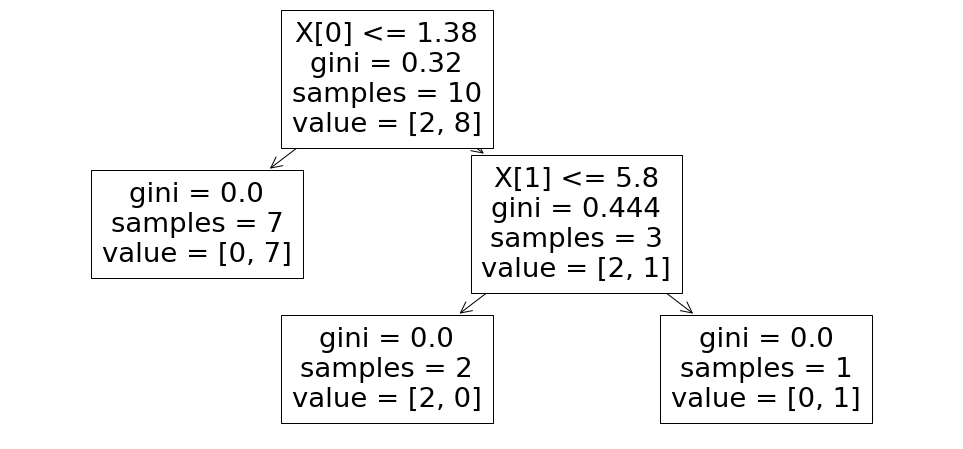

In [46]:
 plt.figure(figsize=(17,8))
 tree.plot_tree(model_LA, max_depth=2)
 plt.show()

###Shift all county Google data by two  months


In [47]:
google_month['Month'] = google_month['Original Month'] + pd.DateOffset(months=2) + pd.offsets.MonthEnd(0) 
google_month

,countyFIPS,Date,retail_recreation,grocery_pharmacy,parks,transit,workplaces,residential,Original Month,delta_retail_recreation,delta_grocery_pharmacy,delta_parks,delta_transit,delta_workplaces,delta_residential,Month
0,1001,2020-01-31,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-31,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-31
1,1001,2020-02-29,4.733333,2.533333,-23.0,NaN,0.266667,0.200000,2020-02-29,NaN,NaN,NaN,NaN,NaN,NaN,2020-04-30
2,1001,2020-03-31,-6.354839,12.612903,-14.0,NaN,-13.419355,6.090909,2020-03-31,-11.088172,10.079570,9.0,NaN,-13.686022,5.890909,2020-05-31
3,1001,2020-04-30,-25.700000,4.033333,-49.5,NaN,-37.833333,15.863636,2020-04-30,-19.345161,-8.579570,-35.5,NaN,-24.413978,9.772727,2020-06-30
4,1001,2020-05-31,-3.677419,13.548387,NaN,NaN,-27.451613,10.850000,2020-05-31,22.022581,9.515054,NaN,NaN,10.381720,-5.013636,2020-07-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37723,56045,2020-08-31,NaN,NaN,NaN,NaN,-23.200000,NaN,2020-08-31,NaN,NaN,NaN,NaN,2.365217,NaN,2020-10-31
37724,56045,2020-09-30,NaN,NaN,NaN,NaN,-14.000000,NaN,2020-09-30,NaN,NaN,NaN,NaN,9.200000,NaN,2020-11-30
37725,56045,2020-10-31,NaN,NaN,NaN,NaN,-13.272727,NaN,2020-10-31,NaN,NaN,NaN,NaN,0.727273,NaN,2020-12-31
37726,56045,2020-11-30,NaN,NaN,NaN,NaN,-24.095238,NaN,2020-11-30,NaN,NaN,NaN,NaN,-10.822511,NaN,2021-01-31


###Merge Incremental cases and Google DataFrames for all counties

In [48]:
merged_all = pd.merge(inc_cases_month, google_month, on=['countyFIPS', 'Month'], suffixes=('', '_DROP'), how='inner').filter(regex='^(?!.*_DROP)')
merged_all

,countyFIPS,Date,Incremental Cases,population,Month,Case Change,retail_recreation,grocery_pharmacy,parks,transit,workplaces,residential,Original Month,delta_retail_recreation,delta_grocery_pharmacy,delta_parks,delta_transit,delta_workplaces,delta_residential
0,1001,2020-03-31,0.225806,55869,2020-03-31,0.225806,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-31,NaN,NaN,NaN,NaN,NaN,NaN
1,1001,2020-04-30,1.166667,55869,2020-04-30,0.940860,4.733333,2.533333,-23.0,NaN,0.266667,0.200000,2020-02-29,NaN,NaN,NaN,NaN,NaN,NaN
2,1001,2020-05-31,5.741935,55869,2020-05-31,4.575269,-6.354839,12.612903,-14.0,NaN,-13.419355,6.090909,2020-03-31,-11.088172,10.079570,9.0,NaN,-13.686022,5.890909
3,1001,2020-06-30,10.566667,55869,2020-06-30,4.824731,-25.700000,4.033333,-49.5,NaN,-37.833333,15.863636,2020-04-30,-19.345161,-8.579570,-35.5,NaN,-24.413978,9.772727
4,1001,2020-07-31,15.419355,55869,2020-07-31,4.852688,-3.677419,13.548387,NaN,NaN,-27.451613,10.850000,2020-05-31,22.022581,9.515054,NaN,NaN,10.381720,-5.013636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31435,56045,2020-08-31,0.451613,6927,2020-08-31,0.354839,NaN,NaN,NaN,NaN,-24.727273,NaN,2020-06-30,NaN,NaN,NaN,NaN,5.701299,NaN
31436,56045,2020-09-30,0.666667,6927,2020-09-30,0.215054,NaN,NaN,NaN,NaN,-25.565217,NaN,2020-07-31,NaN,NaN,NaN,NaN,-0.837945,NaN
31437,56045,2020-10-31,3.870968,6927,2020-10-31,3.204301,NaN,NaN,NaN,NaN,-23.200000,NaN,2020-08-31,NaN,NaN,NaN,NaN,2.365217,NaN
31438,56045,2020-11-30,7.933333,6927,2020-11-30,4.062366,NaN,NaN,NaN,NaN,-14.000000,NaN,2020-09-30,NaN,NaN,NaN,NaN,9.200000,NaN


### Convert all county data to catagorical

In [49]:
merged_all = merged_all.fillna(0)
merged_all['case_direction'] = merged_all['Case Change'].apply(convert_to_categorical)
merged_all

,countyFIPS,Date,Incremental Cases,population,Month,Case Change,retail_recreation,grocery_pharmacy,parks,transit,workplaces,residential,Original Month,delta_retail_recreation,delta_grocery_pharmacy,delta_parks,delta_transit,delta_workplaces,delta_residential,case_direction
0,1001,2020-03-31,0.225806,55869,2020-03-31,0.225806,0.000000,0.000000,0.0,0.0,0.000000,0.000000,2020-01-31,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1
1,1001,2020-04-30,1.166667,55869,2020-04-30,0.940860,4.733333,2.533333,-23.0,0.0,0.266667,0.200000,2020-02-29,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1
2,1001,2020-05-31,5.741935,55869,2020-05-31,4.575269,-6.354839,12.612903,-14.0,0.0,-13.419355,6.090909,2020-03-31,-11.088172,10.079570,9.0,0.0,-13.686022,5.890909,1
3,1001,2020-06-30,10.566667,55869,2020-06-30,4.824731,-25.700000,4.033333,-49.5,0.0,-37.833333,15.863636,2020-04-30,-19.345161,-8.579570,-35.5,0.0,-24.413978,9.772727,1
4,1001,2020-07-31,15.419355,55869,2020-07-31,4.852688,-3.677419,13.548387,0.0,0.0,-27.451613,10.850000,2020-05-31,22.022581,9.515054,0.0,0.0,10.381720,-5.013636,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31435,56045,2020-08-31,0.451613,6927,2020-08-31,0.354839,0.000000,0.000000,0.0,0.0,-24.727273,0.000000,2020-06-30,0.000000,0.000000,0.0,0.0,5.701299,0.000000,1
31436,56045,2020-09-30,0.666667,6927,2020-09-30,0.215054,0.000000,0.000000,0.0,0.0,-25.565217,0.000000,2020-07-31,0.000000,0.000000,0.0,0.0,-0.837945,0.000000,1
31437,56045,2020-10-31,3.870968,6927,2020-10-31,3.204301,0.000000,0.000000,0.0,0.0,-23.200000,0.000000,2020-08-31,0.000000,0.000000,0.0,0.0,2.365217,0.000000,1
31438,56045,2020-11-30,7.933333,6927,2020-11-30,4.062366,0.000000,0.000000,0.0,0.0,-14.000000,0.000000,2020-09-30,0.000000,0.000000,0.0,0.0,9.200000,0.000000,1


### Prepare and apply the model to all counties

In [50]:
y_all = merged_all['case_direction'].values
X_all = merged_all[['delta_retail_recreation', 
                    'delta_grocery_pharmacy', 
                    'delta_parks', 
                    'delta_transit', 
                    'delta_workplaces', 
                    'delta_residential']].values
X_all.shape

(31440, 6)

In [51]:
y_all.shape

(31440,)

In [52]:
decision_tree_all = DecisionTreeClassifier()
model_all = decision_tree_all.fit(X_all, y_all)

In [53]:
X_all.shape

(31440, 6)

In [54]:
print(decision_tree_all.feature_importances_)

[0.1799668  0.15383551 0.06577096 0.08553931 0.41025648 0.10463094]


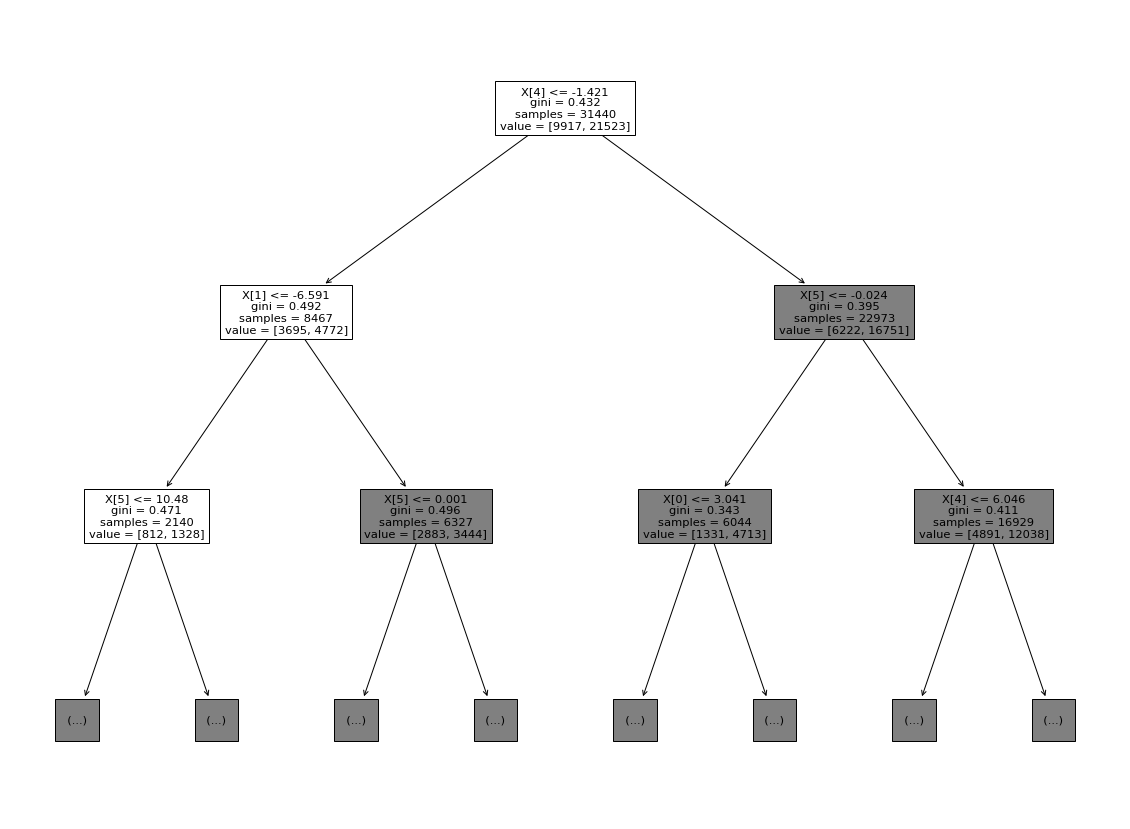

In [55]:
plt.figure(figsize=(20,15))
tree.plot_tree(model_all, max_depth=2)
plt.show()

In [56]:
merged_all.to_csv('/content/drive/MyDrive/COVID_Project/output/merged_all_2_months_lag.csv')

##DM4.6 Classify all counties using a different lag

###Shift all counties by a different lag - 3 months

In [57]:
google_month['Month'] = google_month['Original Month'] + pd.DateOffset(months=3) + pd.offsets.MonthEnd(0) 
google_month

,countyFIPS,Date,retail_recreation,grocery_pharmacy,parks,transit,workplaces,residential,Original Month,delta_retail_recreation,delta_grocery_pharmacy,delta_parks,delta_transit,delta_workplaces,delta_residential,Month
0,1001,2020-01-31,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-31,NaN,NaN,NaN,NaN,NaN,NaN,2020-04-30
1,1001,2020-02-29,4.733333,2.533333,-23.0,NaN,0.266667,0.200000,2020-02-29,NaN,NaN,NaN,NaN,NaN,NaN,2020-05-31
2,1001,2020-03-31,-6.354839,12.612903,-14.0,NaN,-13.419355,6.090909,2020-03-31,-11.088172,10.079570,9.0,NaN,-13.686022,5.890909,2020-06-30
3,1001,2020-04-30,-25.700000,4.033333,-49.5,NaN,-37.833333,15.863636,2020-04-30,-19.345161,-8.579570,-35.5,NaN,-24.413978,9.772727,2020-07-31
4,1001,2020-05-31,-3.677419,13.548387,NaN,NaN,-27.451613,10.850000,2020-05-31,22.022581,9.515054,NaN,NaN,10.381720,-5.013636,2020-08-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37723,56045,2020-08-31,NaN,NaN,NaN,NaN,-23.200000,NaN,2020-08-31,NaN,NaN,NaN,NaN,2.365217,NaN,2020-11-30
37724,56045,2020-09-30,NaN,NaN,NaN,NaN,-14.000000,NaN,2020-09-30,NaN,NaN,NaN,NaN,9.200000,NaN,2020-12-31
37725,56045,2020-10-31,NaN,NaN,NaN,NaN,-13.272727,NaN,2020-10-31,NaN,NaN,NaN,NaN,0.727273,NaN,2021-01-31
37726,56045,2020-11-30,NaN,NaN,NaN,NaN,-24.095238,NaN,2020-11-30,NaN,NaN,NaN,NaN,-10.822511,NaN,2021-02-28


In [58]:
merged_all = pd.merge(inc_cases_month, google_month, on=['countyFIPS', 'Month'], suffixes=('', '_DROP'), how='inner').filter(regex='^(?!.*_DROP)')
merged_all

,countyFIPS,Date,Incremental Cases,population,Month,Case Change,retail_recreation,grocery_pharmacy,parks,transit,workplaces,residential,Original Month,delta_retail_recreation,delta_grocery_pharmacy,delta_parks,delta_transit,delta_workplaces,delta_residential
0,1001,2020-04-30,1.166667,55869,2020-04-30,0.940860,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-31,NaN,NaN,NaN,NaN,NaN,NaN
1,1001,2020-05-31,5.741935,55869,2020-05-31,4.575269,4.733333,2.533333,-23.0,NaN,0.266667,0.200000,2020-02-29,NaN,NaN,NaN,NaN,NaN,NaN
2,1001,2020-06-30,10.566667,55869,2020-06-30,4.824731,-6.354839,12.612903,-14.0,NaN,-13.419355,6.090909,2020-03-31,-11.088172,10.079570,9.0,NaN,-13.686022,5.890909
3,1001,2020-07-31,15.419355,55869,2020-07-31,4.852688,-25.700000,4.033333,-49.5,NaN,-37.833333,15.863636,2020-04-30,-19.345161,-8.579570,-35.5,NaN,-24.413978,9.772727
4,1001,2020-08-31,13.774194,55869,2020-08-31,-1.645161,-3.677419,13.548387,NaN,NaN,-27.451613,10.850000,2020-05-31,22.022581,9.515054,NaN,NaN,10.381720,-5.013636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28291,56045,2020-08-31,0.451613,6927,2020-08-31,0.354839,NaN,NaN,NaN,NaN,-30.428571,NaN,2020-05-31,NaN,NaN,NaN,NaN,5.480519,NaN
28292,56045,2020-09-30,0.666667,6927,2020-09-30,0.215054,NaN,NaN,NaN,NaN,-24.727273,NaN,2020-06-30,NaN,NaN,NaN,NaN,5.701299,NaN
28293,56045,2020-10-31,3.870968,6927,2020-10-31,3.204301,NaN,NaN,NaN,NaN,-25.565217,NaN,2020-07-31,NaN,NaN,NaN,NaN,-0.837945,NaN
28294,56045,2020-11-30,7.933333,6927,2020-11-30,4.062366,NaN,NaN,NaN,NaN,-23.200000,NaN,2020-08-31,NaN,NaN,NaN,NaN,2.365217,NaN


In [59]:
merged_all = merged_all.fillna(0)
merged_all['case_direction'] = merged_all['Case Change'].apply(convert_to_categorical)
merged_all

,countyFIPS,Date,Incremental Cases,population,Month,Case Change,retail_recreation,grocery_pharmacy,parks,transit,workplaces,residential,Original Month,delta_retail_recreation,delta_grocery_pharmacy,delta_parks,delta_transit,delta_workplaces,delta_residential,case_direction
0,1001,2020-04-30,1.166667,55869,2020-04-30,0.940860,0.000000,0.000000,0.0,0.0,0.000000,0.000000,2020-01-31,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1
1,1001,2020-05-31,5.741935,55869,2020-05-31,4.575269,4.733333,2.533333,-23.0,0.0,0.266667,0.200000,2020-02-29,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1
2,1001,2020-06-30,10.566667,55869,2020-06-30,4.824731,-6.354839,12.612903,-14.0,0.0,-13.419355,6.090909,2020-03-31,-11.088172,10.079570,9.0,0.0,-13.686022,5.890909,1
3,1001,2020-07-31,15.419355,55869,2020-07-31,4.852688,-25.700000,4.033333,-49.5,0.0,-37.833333,15.863636,2020-04-30,-19.345161,-8.579570,-35.5,0.0,-24.413978,9.772727,1
4,1001,2020-08-31,13.774194,55869,2020-08-31,-1.645161,-3.677419,13.548387,0.0,0.0,-27.451613,10.850000,2020-05-31,22.022581,9.515054,0.0,0.0,10.381720,-5.013636,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28291,56045,2020-08-31,0.451613,6927,2020-08-31,0.354839,0.000000,0.000000,0.0,0.0,-30.428571,0.000000,2020-05-31,0.000000,0.000000,0.0,0.0,5.480519,0.000000,1
28292,56045,2020-09-30,0.666667,6927,2020-09-30,0.215054,0.000000,0.000000,0.0,0.0,-24.727273,0.000000,2020-06-30,0.000000,0.000000,0.0,0.0,5.701299,0.000000,1
28293,56045,2020-10-31,3.870968,6927,2020-10-31,3.204301,0.000000,0.000000,0.0,0.0,-25.565217,0.000000,2020-07-31,0.000000,0.000000,0.0,0.0,-0.837945,0.000000,1
28294,56045,2020-11-30,7.933333,6927,2020-11-30,4.062366,0.000000,0.000000,0.0,0.0,-23.200000,0.000000,2020-08-31,0.000000,0.000000,0.0,0.0,2.365217,0.000000,1


In [60]:
y_all = merged_all['case_direction'].values
X_all = merged_all[['delta_retail_recreation', 
                    'delta_grocery_pharmacy', 
                    'delta_parks', 
                    'delta_transit', 
                    'delta_workplaces', 
                    'delta_residential']].values
X_all.shape

(28296, 6)

In [61]:
y_all.shape

(28296,)

In [62]:
X_all.shape

(28296, 6)

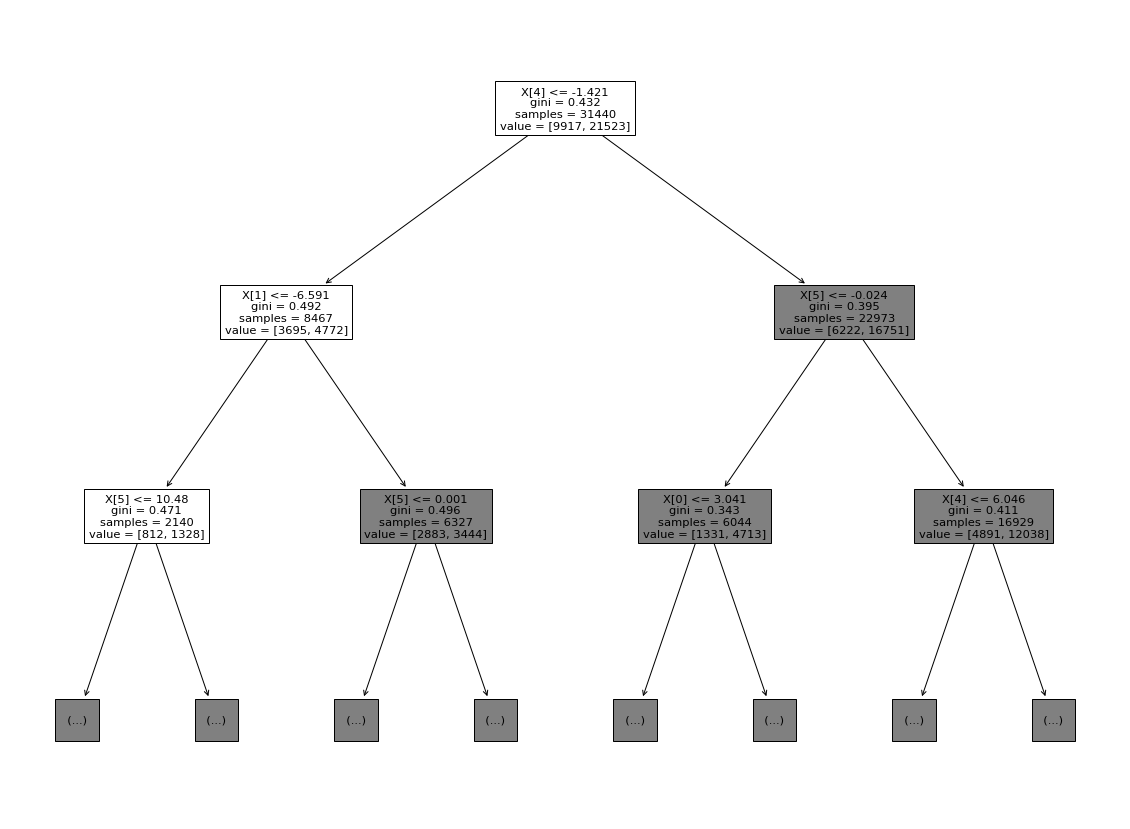

In [63]:
plt.figure(figsize=(20,15))
tree.plot_tree(model_all, max_depth=2)
plt.show()